Задание 1. A/B–тестирование

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
%matplotlib inline

In [45]:
group = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-l-lev/proekt_1/Проект_2_groups (1).csv', sep=';')
group
# Записываем и открываем таблицу groups


,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


In [46]:
add_gr = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-l-lev/proekt_1/Проект_2_group_add (1).csv')
add_gr
# Записываем и открываем таблицу group_add


,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [47]:
# Объеденяю 2 таблицы, чтобы получить все данные участников
df = pd.concat([group, add_gr])

In [48]:
# Переименовываем столбец id, чтобы в дальнейшем объеденить группы 
# студентов с таблицей check
df = df.rename(columns={'id': 'student_id'})
df

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


In [49]:
active = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-l-lev/proekt_1/Проект_2_active_studs (1).csv')
active
# Записываем и открываем таблицу active

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369
...,...
8336,1794344
8337,296883
8338,3598448
8339,3610547


In [50]:
check = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-l-lev/proekt_1/Проект_2_checks (1).csv', sep=';')
check
# Записываем и открываем таблицу check

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0
...,...,...
536,5645737,1900.0
537,5651566,1900.0
538,5662322,1900.0
539,5681918,1900.0


In [63]:
df_act =  df.merge(active,how='inner', on='student_id')

In [64]:
df_che = df.merge(check,how='inner', on='student_id')

In [65]:
df_A = df_che.query('grp == "A"')

In [66]:
df_B = df_che.query('grp == "B"')

In [67]:
df_A

,student_id,grp,rev
0,1627,A,990.0
9,114366,A,690.0
16,212994,A,690.0
17,218393,A,690.0
18,225541,A,690.0
...,...,...,...
517,5394575,A,990.0
525,5545563,A,1160.0
529,5557468,A,290.0
531,5567520,A,489.0


In [68]:
df_B

,student_id,grp,rev
1,3185,B,690.0
2,25973,B,690.0
3,26280,B,690.0
4,100300,B,990.0
5,100645,B,630.0
...,...,...,...
536,5645737,B,1900.0
537,5651566,B,1900.0
538,5662322,B,1900.0
539,5681918,B,1900.0


In [19]:
# По таблицам видно, что колличество участников в группах сильно различается. То лучше всего будет использовать бустрап 
# H0 - Изменения никак не помогли(переменные не различаются) Н1 - Изменения стат значимы(перееменные различаются стат значимо)

In [20]:
from scipy.stats import norm
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [69]:
def get_bootstrap(
    df_A, # числовые значения первой выборки
    df_B, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = df_A.sample(
            len(df_A), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = df_B.sample(
            len(df_B), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

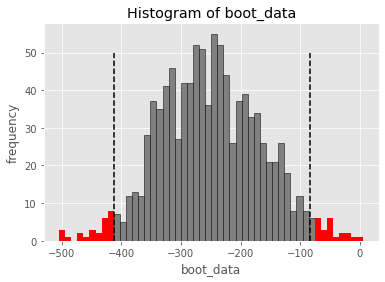

In [70]:
booted_data = get_bootstrap(df_A.rev, df_B.rev)

In [23]:
# Как видно из гисторграммы, 0 в доверительный интервал не попал, значит H0 не применяется(различия не стат.значимы). ОТсюда следует, что 

In [71]:
booted_data["p_value"] # p_value меньше 0.05, значит верна H1 гипотеза

0.002972190542706736

In [82]:
A_ARPU = df_A.rev.sum()/ 74576 #ARPU считается как: выручка / кол-во пользователей
A_ARPPU= df_A.rev.sum()/ 541 #ARPU считается как: выручка / кол-во платящих пользователей

In [83]:
B_ARPU= df_B.rev.sum() / 74576
B_ARPPU= df_B.rev.sum() / 541

In [78]:
CR_A = 107 / 8341 # СR считается как: кол-во заплативших / кол-во активных
CR_B = 434 / 8341

In [84]:
B_ARPU/A_ARPU # Видно, что в группе B ARPU больше в 5 раз

5.225308412960389

In [85]:
B_ARPPU/A_ARPPU # Видно, что в группе B ARPU больше в 5 раз

5.225308412960389

In [79]:
CR_B/CR_A #CR в группе B в 4 раза больше, чем в A

4.05607476635514

1) Как было описано выше, из-за раазныцы в выборках, было решено использовать bootstrap
2) В группе B показатели ARPU,ARPPU и CR больше в разы, чем в A. Думаю, что это связано с количеством выброк в группах и тем, что эксперимент был удачен.
 Подытожив можно сказать, что новую механику запускать можно.

In [ ]:
Задание 2. SQL

In [ ]:
SELECT  DISTINCT st_id, SUM (correct) as ps
FROM peas
GROUP BY  st_id 
HAVING ps >= 20

Получился 131 человек

In [ ]:
SELECT test_grp, SUM(money)/countIf(test_grp='control' OR test_grp='pilot') AS ARPU,
        SUM(money)/countIf(money > 0) as ARPAU,
        SUM(conv) / total_id as CR,
        SUM(conv) / countIf(total_correct>10) AS CR_active,
        SUM(check_math) / countIf(active_math>10) AS CR_active_math
FROM (SELECT st_id, test_grp, COUNT(DISTINCT st_id) AS total_id
      FROM studs
      GROUP BY st_id, test_grp) as a
    LEFT JOIN (SELECT st_id, SUM(correct) AS total_correct, SUMIf(correct, subject='Math') AS active_math
                FROM peas
                GROUP BY st_id) as b
    ON a. st_id = b. st_id 
    LEFT JOIN final_project_check AS c
    ON 
        b.st_id = c.st_id
    LEFT JOIN (SELECT  st_id, COUNT( money ) as conv
                FROM final_project_check
                GROUP BY st_id) as d
    ON c. st_id = d. st_id 
    LEFT JOIN ( SELECT st_id,countIf(subject = 'Math') AS check_math
                FROM final_project_check
                GROUP BY st_id) AS f
    ON c.st_id = f.st_id
GROUP BY test_grp, total_id

Получилось 2 тестовые группы: pilot и control. В pilot	ARPU 10669.93, ARPPU 79634.15, CR 71, CR_active 0.6698, 
CR_active_math 1.32
В control	ARPU 4496.75, ARPPU	76944.44, CR 24, CR_active 0.1846, CR_active_math 0.379

In [ ]:
Задание 3. Python

In [ ]:
# Функция, которая подгружает данные и считает среднее по столбцу rev 
def addfiles(file1, file2, file3):
    
    groups = pd.read_csv(file1, sep=';')
    checks = pd.read_csv(file2, sep=';')
    group_add = pd.read_csv(file3)
    groups = groups.rename(columns={'student_id': 'id'})
    checks = checks.rename(columns={'student_id': 'id'})
    df = pd.concat([groups, group_add]).merge(checks, on='id')
    avg_check = df.groupby('grp', as_index=False).agg({'rev': 'mean'}).rename(columns={'rev': 'avg'})
    return (avg_check)

addfiles(download_url_1, download_url_2, download_url_3)

In [ ]:
# Функция, которая строит barplot
def visual(df):
   
    graph = sns.barplot(data=df, x="grp", y="avg_check", hue='grp')  
    return (graph)

visual(function(download_url_1, download_url_2, download_url_3))